In [16]:
import numpy as np
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [9]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [11]:
query = '''select t.type, t.operation, t.amount as t_amount, t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status
from trans t
right join loan l
on t.account_id = l.account_id;'''

data = pd.read_sql_query(query, engine)
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,1100.0,1100.0,,96396.0,12.0,8033.0,B
1,PRIJEM,VKLAD,9900.0,11000.0,,96396.0,12.0,8033.0,B
2,PRIJEM,VKLAD,700.0,700.0,,165960.0,36.0,4610.0,A
3,PRIJEM,,2.9,702.9,UROK,165960.0,36.0,4610.0,A
4,PRIJEM,VKLAD,18972.0,19674.9,,165960.0,36.0,4610.0,A


In [4]:
data.head()

,loan_id,account_id,date,amount,duration,payments,status,loan_description
0,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,B,Defaulter - Contract Finished
1,5316.0,1801.0,930711.0,165960.0,36.0,4610.0,A,Good - Contract Finished
2,6863.0,9188.0,930728.0,127080.0,60.0,2118.0,A,Good - Contract Finished
3,5325.0,1843.0,930803.0,105804.0,36.0,2939.0,A,Good - Contract Finished
4,7240.0,11013.0,930906.0,274740.0,60.0,4579.0,A,Good - Contract Finished


In [5]:
district_table = pd.read_sql_table('district', connection_string)

In [6]:
district_table.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [12]:
data['operation'].value_counts()

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64

In [14]:
pd.crosstab(data['type'],data['operation'])

operation,,PREVOD NA UCET,PREVOD Z UCTU,VKLAD,VYBER,VYBER KARTOU
type,,,,,,
PRIJEM,31337,0,5336,22633,0,0
VYBER,0,0,0,0,5347,0
VYDAJ,0,25796,0,0,64842,790


In [19]:
data['duration'] = data['duration'].astype('object')

In [20]:
num=data.select_dtypes(include = np.number)

In [21]:
num.head()

,t_amount,balance,l_amount,payments
0,1100.0,1100.0,96396.0,8033.0
1,9900.0,11000.0,96396.0,8033.0
2,700.0,700.0,165960.0,4610.0
3,2.9,702.9,165960.0,4610.0
4,18972.0,19674.9,165960.0,4610.0


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

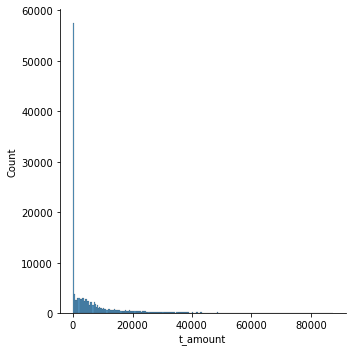

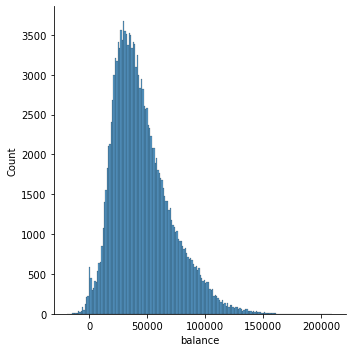

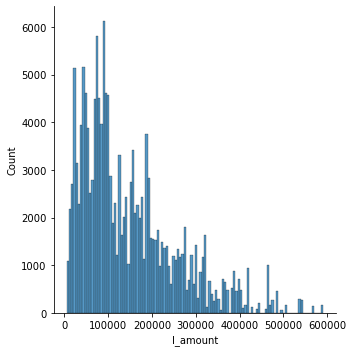

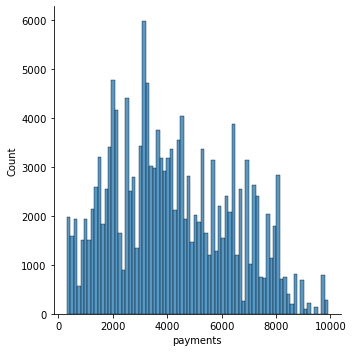

In [28]:
for x in num.columns:
    sns.displot(num[x])
plt.show()

In [29]:
def log_transfom_clean_(x):   #Defining the log transform function
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

In [30]:
balance_log = list(map(log_transfom_clean_, data['balance']))

<ipython-input-29-13da77479ed9>:2: RuntimeWarning: invalid value encountered in log
  x = np.log(x)


In [31]:
t_amount_log = list(map(log_transfom_clean_, data['t_amount']))

<ipython-input-29-13da77479ed9>:2: RuntimeWarning: divide by zero encountered in log
  x = np.log(x)


In [32]:
def feat_log_box(df, feature, bins):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')
    


In [34]:
feat_log_box(data, 't_amount', 120)

<ipython-input-32-808c4e3f93f3>:6: RuntimeWarning: divide by zero encountered in log
  df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) else np.NAN, df[feature]))


NameError: name 'stats' is not defined